In [ ]:
import numpy as np
from imgutils.data import load_image
from imgutils.pose import dwpose_estimate
from unity_controller import UnityController
from scipy.optimize import minimize

def KeyPoint(keypoints):
    """ 提取关键点坐标 (脖子、右肩、左肩、骨盆) """
    return [
        keypoints[0].body[2],  # 脖子
        keypoints[0].body[5],  # 右肩
        keypoints[0].body[7],  # 左肩
        keypoints[0].body[8]   # 骨盆
    ]

# 初始化控制器和参考数据
controller = UnityController()
image_estimate = load_image(r"C:\Users\31878\Desktop\diffusion_pic\00164-1029901126.png")
keypoints_estimate = dwpose_estimate(image_estimate)
target_points = np.array(KeyPoint(keypoints_estimate)).flatten()  # 目标关键点

# 参数边界约束
bounds = [
    (-5, 5), (-5, 5), (0, 5),   # 位置 (x, y, z)
    (-90, 90), (0, 360), (-180, 180),  # 旋转 (x_r, y_r, z_r)
    (30, 90)                    # FOV
]

def generate_view_grid(radius=3.0, num_points=6):
    """ 在球面上生成视角网格，确保相机 lookat (0,0,0) """
    view_grid = []
    theta_steps = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    phi_steps = np.linspace(0, np.pi, num_points, endpoint=False)
    
    for theta in theta_steps:
        for phi in phi_steps:
            # 球坐标转笛卡尔坐标
            x = radius * np.sin(phi) * np.cos(theta)
            y = radius * np.sin(phi) * np.sin(theta)
            z = radius * np.cos(phi)
            
            # 计算方向向量
            lookAtPoint = np.array([0, 1, 0])
            direction = np.array([-x, -y, -z])+lookAtPoint
            distance = np.linalg.norm(direction)
            if distance < 1e-6: continue
            
            forward = direction / distance
            dx, dy, dz = forward[0], forward[1], forward[2]
            
            # 计算yaw和pitch
            yaw = np.degrees(np.arctan2(dx, dz)) % 360
            pitch = -np.degrees(np.arcsin(dy))
            
            view_grid.append([
                x, y, z,        # 位置
                pitch, yaw, 0,  # 旋转（z轴保持0）
                60              # FOV
            ])
    
    return np.array(view_grid)

def get_keypoints(params):
    """ 根据相机参数获取关键点 """
    try:
        img = controller.Control_render(
            x=params[0], y=params[1], z=params[2],
            x_r=params[3], y_r=params[4], z_r=params[5],
            fov=params[6],
            width=1024, height=1024
        )
        kps = dwpose_estimate(img)
        return np.array(KeyPoint(kps)).flatten()
    except Exception as e:
        print(f"渲染失败: {str(e)}")
        return np.full_like(target_points, 1e6)

def loss_function(params):
    """ 计算关键点L2损失 """
    current_points = get_keypoints(params)
    return np.sum((current_points - target_points) ** 2)

def find_best_view(view_grid):
    """ 网格搜索寻找最佳初始视角 """
    min_loss = float('inf')
    best_view = None
    
    for i, view in enumerate(view_grid):
        loss = loss_function(view)
        print(f"视角 {i+1}/{len(view_grid)}: 损失值 = {loss:.2f}")
        if loss < min_loss:
            min_loss = loss
            best_view = view
    
    return best_view, min_loss

def two_stage_optimization(initial_params):
    """ 两阶段优化策略 """
    # 第一阶段：固定FOV优化
    print("\n=== 第一阶段优化（固定FOV）===")
    stage1_bounds = [b for b in bounds]
    stage1_bounds[6] = (initial_params[6], initial_params[6])  # 固定FOV
    
    result = minimize(
        loss_function,
        initial_params,
        method='Powell',
        bounds=stage1_bounds,
        options={'maxiter': 30, 'disp': True}
    )
    
    # 第二阶段：全局优化
    print("\n=== 第二阶段优化（全参数）===")
    final_result = minimize(
        loss_function,
        result.x,
        method='Powell',
        bounds=bounds,
        options={'maxiter': 20, 'disp': True}
    )
    
    return final_result.x

if __name__ == "__main__":
    # 生成初始视角网格
    print("生成视角网格...")
    view_grid = generate_view_grid(radius=2.5, num_points=6)

    # 网格搜索最佳初始视角
    print("\n开始网格搜索...")
    best_view, min_loss = find_best_view(view_grid)
    print(f"\n最佳初始视角：损失值={min_loss:.2f}")
    print(f"初始参数：位置({best_view[0]:.2f}, {best_view[1]:.2f}, {best_view[2]:.2f}) "
          f"旋转({best_view[3]:.1f}, {best_view[4]:.1f}, {best_view[5]:.1f}) FOV={best_view[6]}")

    # 执行两阶段优化
    print("\n开始优化流程...")
    optimized_params = two_stage_optimization(best_view)
    
    # 最终验证
    final_loss = loss_function(optimized_params)
    print(f"\n优化完成！最终损失值：{final_loss:.2f}")
    print("最优参数：")
    print(f"位置：x={optimized_params[0]:.2f}, y={optimized_params[1]:.2f}, z={optimized_params[2]:.2f}")
    print(f"旋转：pitch={optimized_params[3]:.1f}, yaw={optimized_params[4]:.1f}, roll={optimized_params[5]:.1f}")
    print(f"FOV：{optimized_params[6]:.1f}")

    # 保存最终渲染结果
    final_img = controller.Control_render(*optimized_params, width=1024, height=1024)
    final_img.save("optimized_result.png")

In [ ]:
import numpy as np
from scipy.optimize import basinhopping, minimize
import matplotlib.pyplot as plt
from imgutils.data import load_image
from imgutils.pose import dwpose_estimate
from unity_controller import UnityController
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

# ---------------------------
# 核心优化类
# ---------------------------
def KeyPoint(keypoints):
    return [
        keypoints[0].body[2],
        keypoints[0].body[5],
        keypoints[0].body[7],
        keypoints[0].body[8]
    ]
class CameraPoseOptimizer:
    def __init__(self, controller, target_kps, init_position=(0,1,-2), init_rotation=(0,180,0)):
        self.controller = controller
        self.target = np.array(target_kps).flatten()
        
        # 参数初始化（强制背面视角）
        self.params = np.array([
            *init_position,  # x,y,z
            *init_rotation,  # x_r,y_r,z_r
            60.0             # FOV
        ])
        
        # 优化配置
        self.param_weights = np.array([0.1, 0.1, 0.3, 1.0, 2.0, 0.5, 0.2])
        self.best_loss = float('inf')
        self.best_params = None
        self.history = []

        # 并行计算准备
        self.executor = ThreadPoolExecutor(max_workers=4)

    # ---------------------------
    # 核心优化方法
    # ---------------------------
    def optimize(self, global_steps=15, local_steps=30):
        """执行混合优化流程"""
        print("=== 开始全局优化 ===")
        global_result = basinhopping(
            func=self._total_loss,
            x0=self.params,
            niter=global_steps,
            T=1.5,
            stepsize=0.8,
            minimizer_kwargs={
                "method": "L-BFGS-B",
                "bounds": self._get_bounds('global'),
                "options": {"eps": 0.01}
            },
            take_step=self._global_step
        )
        
        print("\n=== 开始局部优化 ===")
        local_result = minimize(
            self._total_loss,
            global_result.x,
            method='Nelder-Mead',
            options={
                'initial_simplex': self._create_simplex(global_result.x),
                'xatol': 0.01,
                'fatol': 10.0,
                'adaptive': True,
                'maxiter': local_steps
            }
        )
        
        self._save_result(local_result.x)
        return self.best_params

    # ---------------------------
    # 优化组件
    # ---------------------------
    def _get_bounds(self, mode):
        """获取参数边界约束"""
        if mode == 'global':
            return [
                (-2, 2), (0, 3), (-5, -0.5),  # 位置
                (-30, 30), (90, 270), (-30, 30),  # 旋转
                (45, 75)  # FOV
            ]
        return [
            (-1, 1), (0.5, 1.5), (-3, -1),  # 位置
            (-15, 15), (160, 200), (-15, 15),  # 旋转
            (50, 70)  # FOV
        ]

    def _global_step(self, x):
        """全局优化步长策略"""
        delta = np.abs(x - self.best_params) if self.best_params is not None else np.ones_like(x)
        step = np.array([0.05, 0.05, 0.2, 0.5, 1.5, 0.3, 0.2])
        scale = np.where(delta > 3*step, 3.0, 1.0)
        return x + np.random.normal(0, step*scale)

    def _create_simplex(self, center):
        """创建带权重的初始单纯形"""
        simplex = [center.copy()]
        for i in range(len(center)):
            delta = 0.02 * self.param_weights[i]
            point = center.copy()
            point[i] += delta
            simplex.append(point)
        return np.array(simplex)

    # ---------------------------
    # 损失函数计算（带缓存）
    # ---------------------------
    @lru_cache(maxsize=100)
    def _cached_render(self, params_tuple):
        """带缓存的渲染方法"""
        try:
            return self.controller.Control_render(
                x=params_tuple[0],
                y=params_tuple[1],
                z=params_tuple[2],
                x_r=params_tuple[3],
                y_r=params_tuple[4],
                z_r=params_tuple[5],
                fov=params_tuple[6],
                width=512,
                height=512
            )
        except:
            return None

    def _compute_kps(self, params):
        """并行计算关键点"""
        params_tuple = tuple(params.tolist())
        img = self._cached_render(params_tuple)
        if img is None:
            return None
        return KeyPoint(dwpose_estimate(img))

    def _direction_penalty(self, params):
        """物理约束惩罚项"""
        # 位置约束（z必须为负）
        pos_penalty = 50.0 if params[2] > 0 else 0.0
        
        # 旋转约束（y轴在160-200之间）
        y_rot = params[4] % 360
        rot_penalty = 20 * abs(y_rot - 180)/180 if not (160 < y_rot < 200) else 0.0
        
        return pos_penalty + rot_penalty

    def _total_loss(self, params):
        """带约束的总损失函数"""
        # 参数范围约束
        params = np.clip(params, 
                        [b[0] for b in self._get_bounds('global')],
                        [b[1] for b in self._get_bounds('global')])
        
        # 异步获取关键点
        future = self.executor.submit(self._compute_kps, params)
        current_kps = future.result()
        
        if current_kps is None:
            return float('inf')
            
        # 计算基础损失
        diff = np.array(current_kps).flatten() - self.target
        base_loss = np.sum(diff ** 2)
        
        # 总损失 = 基础损失 + 方向约束
        total_loss = base_loss + self._direction_penalty(params)
        
        # 记录最佳参数
        if total_loss < self.best_loss:
            self.best_loss = total_loss
            self.best_params = params.copy()
            self._visualize_progress(params, total_loss)
        
        self.history.append(total_loss)
        return total_loss

    # ---------------------------
    # 可视化与工具方法
    # ---------------------------
    def _visualize_progress(self, params, loss):
        """实时可视化优化进度"""
        plt.figure(figsize=(12, 5))
        
        # 显示当前渲染画面
        plt.subplot(1, 2, 1)
        img = self._cached_render(tuple(params.tolist()))
        if img is not None:
            plt.imshow(img)
            plt.title(f"Loss: {loss:.1f}\nParams: {params.round(2)}")
            plt.axis('off')
        
        # 显示损失曲线
        plt.subplot(1, 2, 2)
        plt.plot(self.history)
        plt.yscale('log')
        plt.title("Optimization Progress")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        plt.tight_layout()
        plt.pause(0.1)
        plt.close()

    def _save_result(self, params):
        """保存最终结果"""
        final_img = self.controller.Control_render(
            x=params[0], y=params[1], z=params[2],
            x_r=params[3], y_r=params[4], z_r=params[5],
            fov=params[6],
            width=1024,
            height=1024
        )
        plt.imsave("optimized_view.png", final_img)
        np.save("optimized_params.npy", params)

# ---------------------------
# 使用示例
# ---------------------------
if __name__ == "__main__":
    # 初始化Unity控制器
    controller = UnityController()
    
    # 加载参考图像
    ref_image = load_image(r"C:\Users\31878\Desktop\diffusion_pic\02977-2464155392.png")
    ref_kps = KeyPoint(dwpose_estimate(ref_image))
    
    # 创建优化器并执行优化
    optimizer = CameraPoseOptimizer(
        controller=controller,
        target_kps=ref_kps,
        init_position=(0, 1, -2),    # 初始z坐标为负（背面）
        init_rotation=(0, 180, 0)    # 初始面向背面
    )
    
    optimized_params = optimizer.optimize(
        global_steps=20,   # 全局搜索迭代次数
        local_steps=30     # 局部优化迭代次数
    )
    
    print(f"优化完成！最佳参数：{optimized_params}")

In [ ]:
from imgutils.data import load_image
# from matplotlib import pyplot as plt
from PIL import Image
image_path = r"C:\Users\31878\Desktop\diffusion_pic\10__.png"
image = Image.open(image_path)
image


In [ ]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"

# url = "http://images.cocodataset.org/val2017/000000000139.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image_path = r"C:\Users\31878\Desktop\diffusion_pic\2023-11-01_20-56-19_5959.png"
image = Image.open(image_path)

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose any detector of your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
print(results)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
print(person_boxes)
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]


# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image
import supervision as sv

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)
annotated_frame

---------------------------------------------------------------render----------------------------------------------------

In [ ]:
from imgutils.data import load_image
from imgutils.pose import dwpose_estimate, op18_visualize
image = load_image(r"C:\Users\31878\Desktop\diffusion_pic\00164-1029901126.png")
keypoints = dwpose_estimate(image)
from matplotlib import pyplot as plt
plt.imshow(op18_visualize(image, keypoints))
plt.show()

In [ ]:
def KeyPoint(keypoints):
    """ 提取关键点坐标 (脖子、右肩、左肩、骨盆) """
    return [
        keypoints[0].body[2][:2],  # 脖子
        keypoints[0].body[5][:2],  # 右肩
        keypoints[0].body[7][:2],  # 左肩
        keypoints[0].body[8][:2]   # 骨盆
    ]

In [ ]:

target_points = np.array(KeyPoint(keypoints_estimate)).flatten()  # 目标关键点
target_points

In [ ]:
KeyPoint(keypoints_estimate)

In [ ]:
import numpy as np
from imgutils.data import load_image
from imgutils.pose import dwpose_estimate
from unity_controller import UnityController

def KeyPoint(keypoints, image_width=1024, image_height=1024):
    """ 提取关键点坐标 (脖子、右肩、左肩、骨盆) 并归一化到0-1之间 """
    points = [
        keypoints[0].body[2],  # 脖子
        keypoints[0].body[5],  # 右肩
        keypoints[0].body[7],  # 左肩
        keypoints[0].body[8]   # 骨盆
    ]
    # 归一化到0-1
    normalized_points = []
    for point in points:
        x = point[0] / image_width
        y = point[1] / image_height
        normalized_points.append((x, y))
    return normalized_points

# 初始化控制器和参考数据
controller = UnityController()
image_estimate = load_image(r"C:\Users\31878\Desktop\diffusion_pic\00164-1029901126.png")
keypoints_estimate = dwpose_estimate(image_estimate)
target_points = np.array(KeyPoint(keypoints_estimate)).flatten()  # 目标关键点

# 参数边界约束
bounds = [
    (-5, 5), (-5, 5), (0, 5),   # 位置 (x, y, z)
    (-90, 90), (0, 360), (-180, 180),  # 旋转 (x_r, y_r, z_r)
    (30, 90)                    # FOV
]

def generate_view_grid(radius=3.0, num_points=6):
    """ 在球面上生成视角网格，确保相机 lookat (0,0,0) """
    view_grid = []
    theta_steps = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    phi_steps = np.linspace(0, np.pi, num_points, endpoint=False)
    
    for theta in theta_steps:
        for phi in phi_steps:
            # 球坐标转笛卡尔坐标
            x = radius * np.sin(phi) * np.cos(theta)
            y = radius * np.sin(phi) * np.sin(theta)
            z = radius * np.cos(phi)
            
            # 计算方向向量
            lookAtPoint = np.array([0, 1, 0])
            direction = np.array([-x, -y, -z]) + lookAtPoint
            distance = np.linalg.norm(direction)
            if distance < 1e-6: continue
            
            forward = direction / distance
            dx, dy, dz = forward[0], forward[1], forward[2]
            
            # 计算yaw和pitch
            yaw = np.degrees(np.arctan2(dx, dz)) % 360
            pitch = -np.degrees(np.arcsin(dy))
            
            view_grid.append([
                x, y, z,        # 位置
                pitch, yaw, 0,  # 旋转（z轴保持0）
                60              # FOV
            ])
    
    return np.array(view_grid)

def get_keypoints(params, image_width=1024, image_height=1024):
    """ 根据相机参数获取关键点并归一化到0-1之间 """
    try:
        img = controller.Control_render(
            x=params[0], y=params[1], z=params[2],
            x_r=params[3], y_r=params[4], z_r=params[5],
            fov=params[6],
            width=image_width, height=image_height
        )
        kps = dwpose_estimate(img)
        return np.array(KeyPoint(kps, image_width, image_height)).flatten()
    except Exception as e:
        print(f"渲染失败: {str(e)}")
        return np.full_like(target_points, 1e6)

def loss_function(params):
    """ 计算关键点L2损失 """
    current_points = get_keypoints(params)
    return np.sum((current_points - target_points) ** 2)

def find_best_view(view_grid):
    """ 网格搜索寻找最佳初始视角 """
    min_loss = float('inf')
    best_view = None
    
    for i, view in enumerate(view_grid):
        loss = loss_function(view)
        print(f"视角 {i+1}/{len(view_grid)}: 损失值 = {loss:.2f}")
        if loss < min_loss:
            min_loss = loss
            best_view = view
    
    return best_view, min_loss

def compute_gradient(params, epsilon=1e-8):
    """ 使用数值微分计算梯度 """
    gradient = np.zeros_like(params)
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += epsilon
        loss_plus = loss_function(params_plus)
        
        params_minus = params.copy()
        params_minus[i] -= epsilon
        loss_minus = loss_function(params_minus)
        
        gradient[i] = (loss_plus - loss_minus) / (2 * epsilon)
    
    # 梯度归一化
    gradient_norm = np.linalg.norm(gradient)
    if gradient_norm > 1.0:
        gradient = gradient / gradient_norm
    
    return gradient

def levenberg_marquardt_optimization(initial_params, max_iterations=50, tolerance=1e-6, lambda_=0.01):
    """ 使用Levenberg-Marquardt算法进行优化 """
    params = initial_params.copy()
    loss_prev = loss_function(params)
    
    for iteration in range(max_iterations):
        # 计算梯度
        gradient = compute_gradient(params)
        
        # 计算近似Hessian矩阵（对角线元素）
        H = np.diag(np.abs(gradient)) * lambda_
        
        # 解线性方程组 (H + λI)Δ = -g
        try:
            delta = np.linalg.solve(H + np.eye(len(params)) * lambda_, -gradient)
        except np.linalg.LinAlgError:
            print("矩阵求解失败，尝试增大λ")
            lambda_ *= 10
            continue
        
        # 限制参数更新幅度
        delta_norm = np.linalg.norm(delta)
        if delta_norm > 1.0:
            delta = delta / delta_norm
        
        # 尝试更新参数
        params_new = params + delta
        loss_new = loss_function(params_new)
        
        if loss_new < loss_prev:
            # 更新成功，减小λ
            params = params_new
            loss_prev = loss_new
            lambda_ *= 0.1
            print(f"迭代 {iteration+1}: 损失值 = {loss_prev:.2f} (λ = {lambda_:.4f})")
        else:
            # 更新失败，增大λ
            lambda_ *= 10
            print(f"迭代 {iteration+1}: 损失值未改善，增大λ至 {lambda_:.4f}")
        
        # 检查收敛
        if np.abs(loss_prev - loss_function(params)) < tolerance:
            print("优化收敛，停止迭代")
            break
    
    return params

if __name__ == "__main__":
    # 生成初始视角网格
    print("生成视角网格...")
    view_grid = generate_view_grid(radius=2.5, num_points=6)

    # 网格搜索最佳初始视角
    print("\n开始网格搜索...")
    best_view, min_loss = find_best_view(view_grid)
    print(f"\n最佳初始视角：损失值={min_loss:.2f}")
    print(f"初始参数：位置({best_view[0]:.2f}, {best_view[1]:.2f}, {best_view[2]:.2f}) "
          f"旋转({best_view[3]:.1f}, {best_view[4]:.1f}, {best_view[5]:.1f}) FOV={best_view[6]}")

    # 使用Levenberg-Marquardt算法进行优化
    print("\n开始LM优化...")
    optimized_params = levenberg_marquardt_optimization(best_view)
    
    # 最终验证
    final_loss = loss_function(optimized_params)
    print(f"\n优化完成！最终损失值：{final_loss:.2f}")
    print("最优参数：")
    print(f"位置：x={optimized_params[0]:.2f}, y={optimized_params[1]:.2f}, z={optimized_params[2]:.2f}")
    print(f"旋转：pitch={optimized_params[3]:.1f}, yaw={optimized_params[4]:.1f}, roll={optimized_params[5]:.1f}")
    print(f"FOV：{optimized_params[6]:.1f}")

    # 保存最终渲染结果
    final_img = controller.Control_render(*optimized_params, width=1024, height=1024)
    final_img.save("optimized_result.png")

In [ ]:
def compute_gradient_test(params, epsilon=1e-6):
    """ 使用数值微分计算梯度 """
    gradient = np.zeros_like(params)
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += epsilon
        loss_plus = loss_function(params_plus)
        
        params_minus = params.copy()
        params_minus[i] -= epsilon
        loss_minus = loss_function(params_minus)
        
        gradient[i] = (loss_plus - loss_minus) / (2 * epsilon)
    
    
    return gradient

def levenberg_marquardt_optimization_test(initial_params, max_iterations=50, tolerance=1e-6, lambda_=0.01):
    """ 使用Levenberg-Marquardt算法进行优化 """
    params = initial_params.copy()
    loss_prev = loss_function(params)
    
    for iteration in range(max_iterations):
        # 计算梯度
        gradient = compute_gradient_test(params)
        print(gradient)
        
        # 计算近似Hessian矩阵（对角线元素）
        H = np.diag(np.abs(gradient)) * lambda_
        
        # 解线性方程组 (H + λI)Δ = -g
        delta = np.linalg.solve(H + np.eye(len(params)) * lambda_, -gradient)
        print(delta)
        
        # 尝试更新参数
        params_new = params + delta
        print(params_new)
        loss_new = loss_function(params_new)
        
        if loss_new < loss_prev:
            # 更新成功，减小λ
            params = params_new
            loss_prev = loss_new
            lambda_ *= 0.1
            print(f"迭代 {iteration+1}: 损失值 = {loss_prev:.2f} (λ = {lambda_:.4f})")
        else:
            # 更新失败，增大λ
            lambda_ *= 10
            print(f"迭代 {iteration+1}: 损失值未改善，增大λ至 {lambda_:.4f}")
        
        # 检查收敛
        if np.abs(loss_prev - loss_function(params)) < tolerance:
            print("优化收敛，停止迭代")
            break
    
    return params

In [ ]:
optimized_params = levenberg_marquardt_optimization_test(best_view)

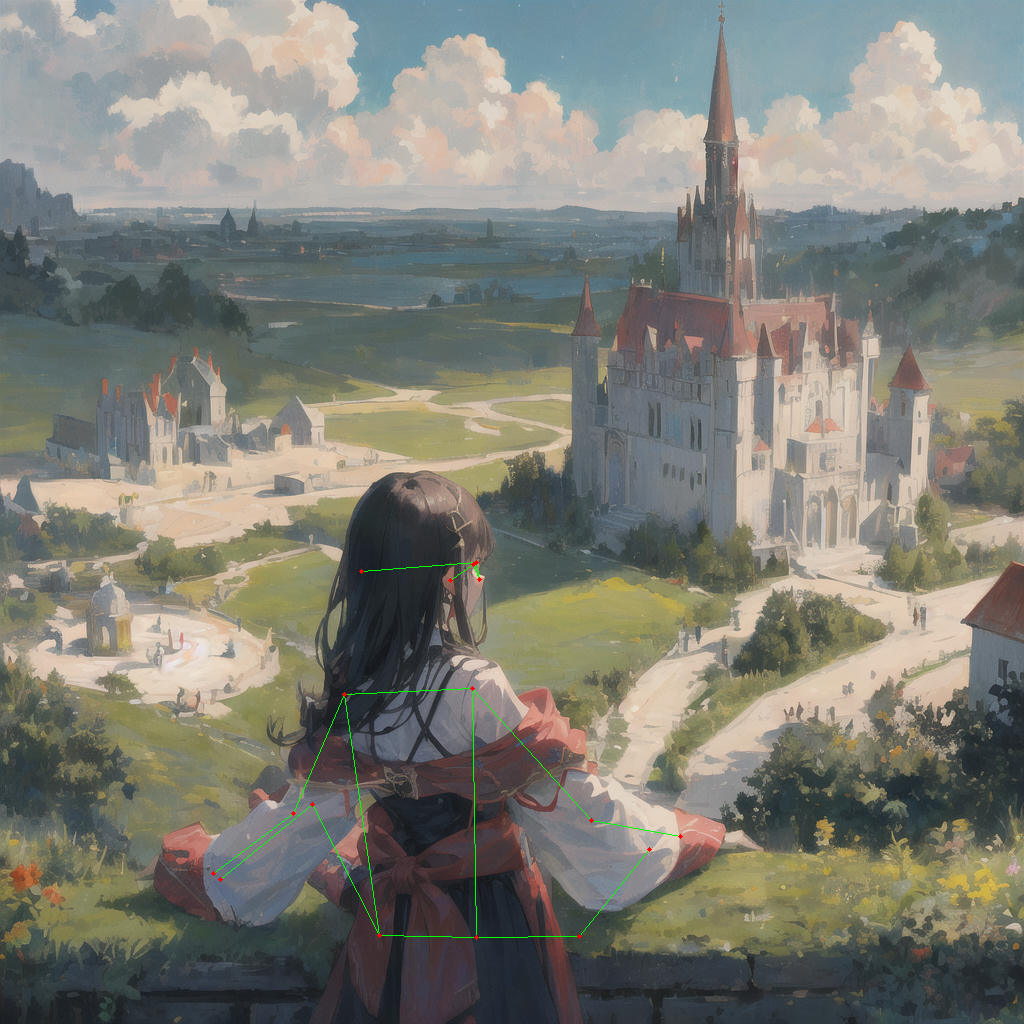

In [25]:
from imgutils.detect import detect_person, detection_visualize
import torch
import requests
import numpy as np
from PIL import Image
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation



device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = r"C:\Users\31878\Desktop\diffusion_pic\00143-3780161293.png"
# image_path = r"C:\Users\31878\Desktop\diffusion_pic\2023-11-01_20-56-19_5959.png"
image = Image.open(image_path)
result = detect_person(image_path)
# print(result[0][0])
# visualized = detection_visualize(image, result)
# visualized
# result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes=result[0][0]

person_boxes = np.array(person_boxes)

# 将 NumPy 数组转换为 PyTorch 张量
person_boxes = torch.tensor(person_boxes, dtype=torch.float32)

# 确保张量的形状为 [1, 4]
person_boxes = person_boxes.unsqueeze(0)  # 添加一个维度

# print(person_boxes)
# person_boxes = result["boxes"][result["labels"] == 0]
# print(person_boxes)
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]


# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image
import supervision as sv

# print(image_pose_result[0][2],image_pose_result[0][5],image_pose_result[0][8],image_pose_result[0][11])
xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)
annotated_frame



In [ ]:
print(image_pose_result[0]['keypoints'][6] )
print(image_pose_result[0]['keypoints'][5] )
print(image_pose_result[0]['keypoints'][12] )
print(image_pose_result[0]['keypoints'][11] )
# image_pose_result[0]['keypoints'][6] #right shoulder  Bip001 R UpperArm (0.10, 1.20, -0.01)
# image_pose_result[0]['keypoints'][5] #left shoulder   Bip001 L UpperArm (-0.10, 1.20, -0.01)
# image_pose_result[0]['keypoints'][12] #right hip  Bip001 R Thigh  (0.08, 0.88, 0.02)
# image_pose_result[0]['keypoints'][11] #left hip  Bip001 L Thigh (-0.07, 0.87, 0.03)

In [ ]:
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, VitPoseForPoseEstimation
from imgutils.detect import detect_person

# 提取关键点坐标 (脖子、右肩、左肩、骨盆)
def KeyPoint(image_pose_result, image_width, image_height):
    if image_pose_result is None or len(image_pose_result) == 0:
        return None
    keypoints = image_pose_result[0]['keypoints']
    return [
        [(keypoints[5][0].item() / image_width), 1-(keypoints[5][1].item() / image_height)],  
        [(keypoints[6][0].item() / image_width), 1-(keypoints[6][1].item() / image_height)],  
        [(keypoints[11][0].item() / image_width), 1-(keypoints[11][1].item() / image_height)], 
        [(keypoints[12][0].item() / image_width), 1-(keypoints[12][1].item() / image_height)]  
    ]

# 检测人物并估计姿态
def detect_and_estimate_pose(image_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image = Image.open(image_path)

    result = detect_person(image_path)
    person_boxes = result[0][0]
    if not person_boxes:
        print("No person detected in the image.")
        return None

    person_boxes = np.array(person_boxes, dtype=np.float32)
    if person_boxes.ndim == 1:
        person_boxes = person_boxes[np.newaxis, :]
    person_boxes[:, 2] -= person_boxes[:, 0]
    person_boxes[:, 3] -= person_boxes[:, 1]

    processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
    model = VitPoseForPoseEstimation.from_pretrained(
        "usyd-community/vitpose-base-simple", device_map=device
    )
    inputs = processor(image, boxes=[person_boxes], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    pose_results = processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
    return pose_results[0] if pose_results else None

def make_unity_view_matrix(pos, euler_deg, include_z_flip: bool = True) -> np.ndarray:
    pos = np.asarray(pos, dtype=np.float32)
    euler_deg = np.asarray(euler_deg, dtype=np.float32)
    pitch, yaw, roll = np.deg2rad(euler_deg)
    Rz = np.array([[ np.cos(roll), -np.sin(roll), 0], [ np.sin(roll),  np.cos(roll), 0], [ 0, 0, 1]], dtype=np.float32)
    Rx = np.array([[1, 0, 0], [0, np.cos(pitch), -np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]], dtype=np.float32)
    Ry = np.array([[ np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]], dtype=np.float32)
    Rcw = Ry @ Rx @ Rz
    view_rot = Rcw.T
    view_trans = -view_rot @ pos
    view = np.eye(4, dtype=np.float32)
    view[:3, :3] = view_rot
    view[:3,  3] = view_trans
    if include_z_flip:
        flipZ = np.diag([1, 1, -1, 1]).astype(np.float32)
        view = flipZ @ view
    return view

def perspective_projection(fov_deg, aspect, near, far) -> np.ndarray:
    f = 1.0 / np.tan(np.deg2rad(fov_deg) * 0.5)
    M = np.zeros((4,4), dtype=np.float32)
    M[0,0] = f / aspect
    M[1,1] = f
    M[2,2] = -(far / (far - near))
    M[2,3] = near * far / (far - near)
    M[3,2] = -1.0
    return M

def project_point(point_3d, camera_params, image_width=1024, image_height=1024, fov_deg=60.0, fixed_roll=0.0):
    if len(camera_params) == 5:
        px, py, pz, pitch, yaw = camera_params
        roll = fixed_roll
    else:
        px, py, pz, pitch, yaw, roll = camera_params

    view = make_unity_view_matrix([px, py, pz], [pitch, yaw, roll], include_z_flip=True)
    aspect = image_width / image_height
    proj = perspective_projection(fov_deg, aspect, near=0.1, far=1000.0)
    # print(view)
    # print(proj)
    mvp = proj @ view
    pt_h = np.array([*point_3d, 1.0], dtype=np.float32)
    clip = mvp @ pt_h
    ndc = clip[:3] / (clip[3] if clip[3] != 0 else 1)
    sx = (ndc[0] + 1) * 0.5
    sy = (ndc[1] + 1) * 0.5
    return np.array([sx, sy])

# 加入方向比例残差
def pairwise_vector_ratios(points):
    p = np.array(points)
    v01 = p[1] - p[0]
    v23 = p[3] - p[2]
    v02 = p[2] - p[0]
    v13 = p[3] - p[1]
    ratios = np.array([
        v01[0], v01[1],
        v23[0], v23[1],
        v02[0], v02[1],
        v13[0], v13[1],
    ], dtype=np.float32)
    return ratios

def compute_residuals(camera_params, local_points, screen_points, fixed_roll=0.0, ratio_weight=1.0):
    residuals = []
    projected_points = []
    for local, screen in zip(local_points, screen_points):
        proj = project_point(local, camera_params, fixed_roll=fixed_roll)
        projected_points.append(proj)
        residuals.extend(proj - screen)

    # 加入方向向量残差（非长度）
    screen_vec = pairwise_vector_ratios(screen_points)
    proj_vec = pairwise_vector_ratios(projected_points)
    ratio_residuals = (proj_vec - screen_vec) * ratio_weight
    residuals.extend(ratio_residuals)

    return np.array(residuals, dtype=np.float32)

def compute_jacobian(camera_params, local_points, screen_points, fixed_roll=0.0, ratio_weight=1.0):
    n_params = len(camera_params)
    eps = 1e-6 * (1 + np.abs(camera_params))
    base = compute_residuals(camera_params, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)
    J = np.zeros((base.size, n_params), dtype=np.float32)
    for i in range(n_params):
        p2 = camera_params.copy()
        p2[i] += eps[i]
        r2 = compute_residuals(p2, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)
        J[:, i] = (r2 - base) / eps[i]
    return J

def levenberg_marquardt_optimization(camera_params, local_points, screen_points, max_iter=200, tol=1e-6, fixed_roll=0.0, ratio_weight=1.0):
    lam = 1e-3
    cost = np.sum(compute_residuals(camera_params, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)**2)
    for _ in range(max_iter):
        r = compute_residuals(camera_params, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)
        J = compute_jacobian(camera_params, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)
        A = J.T @ J
        g = J.T @ r
        diag = np.diag(A)
        L = lam * np.diag(diag + 1e-6)
        try:
            dp = np.linalg.solve(A + L, -g)
        except np.linalg.LinAlgError:
            break
        new_p = camera_params + dp
        new_cost = np.sum(compute_residuals(new_p, local_points, screen_points, fixed_roll=fixed_roll, ratio_weight=ratio_weight)**2)
        if new_cost < cost:
            camera_params = new_p
            cost = new_cost
            lam *= 0.1
            if np.linalg.norm(dp) < tol:
                break
        else:
            lam *= 10
    return camera_params

# 主程序
if __name__ == "__main__":
    image_path = r"C:\Users\31878\Desktop\diffusion_pic\00143-3780161293.png"
    pose_res = detect_and_estimate_pose(image_path)
    screen_pts = KeyPoint(pose_res, 1024, 1024)
    local_pts = np.array([
        [-0.10, 1.20, -0.01],
        [ 0.10, 1.20, -0.01],
        [-0.07, 0.87,  0.03],
        [ 0.08, 0.88,  0.02]
    ], dtype=np.float32)

    init_pos = np.array([0.0, 1.0, 1.0], dtype=np.float32)
    init_rot = np.array([0.0, 180.0], dtype=np.float32)  # pitch, yaw
    camera_params = np.concatenate([init_pos, init_rot])  # 没有 roll

    print("初始投影:")
    for i, pt in enumerate(local_pts):
        print(i, project_point(pt, camera_params, fixed_roll=0.0), screen_pts[i])

    initial_res = compute_residuals(camera_params, local_pts, np.array(screen_pts), fixed_roll=0.0, ratio_weight=0.5)
    initial_cost = np.sum(initial_res**2)
    print("\n初始残差:", initial_res)
    print(f"初始残差平方和 (cost): {initial_cost:.6f}\n")

    opt_params = levenberg_marquardt_optimization(camera_params, local_pts, np.array(screen_pts), fixed_roll=0.0, ratio_weight=0.5)

    print("\n优化后参数(固定 roll=0):", [f"{x:.4f}" for x in opt_params])
    optimized_res = compute_residuals(opt_params, local_pts, np.array(screen_pts), fixed_roll=0.0, ratio_weight=0.5)
    optimized_cost = np.sum(optimized_res**2)
    print("优化后残差:", optimized_res)
    print(f"优化后残差平方和 (cost): {optimized_cost:.6f}\n")

    print("优化后投影:")
    for i, pt in enumerate(local_pts):
        print(i, project_point(pt, opt_params, fixed_roll=0.0), screen_pts[i])


初始投影:
0 [0.58574501 0.67149018] [0.3364279270172119, 0.32170259952545166]
1 [0.41425484 0.67149018] [0.46145719289779663, 0.32729125022888184]
2 [0.5624966  0.38393477] [0.3710254430770874, 0.08646321296691895]
3 [0.42930397 0.3939561 ] [0.46486896276474, 0.08462762832641602]

初始残差: [ 0.24931708  0.3497876  -0.04720236  0.34419894  0.19147116  0.29747155
 -0.03556499  0.30932847 -0.29651946 -0.00558865 -0.22703615  0.01185692
 -0.05784593 -0.05231601  0.01163737 -0.03487045]
初始残差平方和 (cost): 0.674386


优化后参数(固定 roll=0): ['-0.3576', '1.7066', '2.2563', '-2.5993', '177.0287']
优化后残差: [ 0.10979694 -0.05610199 -0.09146529 -0.06079736  0.06127385  0.04425016
 -0.09034765  0.05270681 -0.20126224 -0.00469537 -0.15162149  0.00845665
 -0.04852309  0.10035215  0.00111765  0.11350417]
优化后残差平方和 (cost): 0.132817

优化后投影:
0 [0.44622487 0.26560061] [0.3364279270172119, 0.32170259952545166]
1 [0.3699919  0.26649389] [0.46145719289779663, 0.32729125022888184]
2 [0.43229929 0.13071337] [0.3710254430770874,

In [13]:
import numpy as np

def make_unity_view_matrix(pos, euler_deg, include_z_flip: bool = True) -> np.ndarray:
    """
    Compute Unity's view matrix (world->camera).

    Parameters
    ----------
    pos : array_like, shape (3,)
        Camera position in world space [x, y, z].
    euler_deg : array_like, shape (3,)
        Camera Euler angles in degrees [pitch=X, yaw=Y, roll=Z].
    include_z_flip : bool
        If True, produce Camera.worldToCameraMatrix (camera-space forward = -Z).
        If False, produce transform.worldToLocalMatrix (pure inverse transform).

    Returns
    -------
    view : ndarray, shape (4,4)
        The view matrix.
    """
    # --- 强制转为 ndarray ---
    pos        = np.asarray(pos, dtype=np.float32)
    euler_deg  = np.asarray(euler_deg, dtype=np.float32)

    # 1) Euler → radians，注意这里直接对长度-3 的 array 调用
    pitch, yaw, roll = np.deg2rad(euler_deg)

    # 2) 各轴旋转矩阵（Extrinsic Z→X→Y）
    Rz = np.array([[ np.cos(roll), -np.sin(roll), 0],
                   [ np.sin(roll),  np.cos(roll), 0],
                   [            0,             0, 1]], dtype=np.float32)

    Rx = np.array([[1,             0,              0],
                   [0,  np.cos(pitch), -np.sin(pitch)],
                   [0,  np.sin(pitch),  np.cos(pitch)]], dtype=np.float32)

    Ry = np.array([[ np.cos(yaw), 0, np.sin(yaw)],
                   [           0, 1,          0],
                   [-np.sin(yaw), 0, np.cos(yaw)]], dtype=np.float32)

    # 3) Camera 在世界空间的旋转矩阵
    Rcw = Ry @ Rx @ Rz

    # 4) 求逆（R^T + 平移）
    view_rot   = Rcw.T
    view_trans = -view_rot @ pos

    # 5) 组装 4×4
    view = np.eye(4, dtype=np.float32)
    view[:3, :3] = view_rot
    view[:3,  3] = view_trans

    # 6) 如果要和 Unity 的 Camera.worldToCameraMatrix 一致（camera-space forward = -Z）
    if include_z_flip:
        flipZ = np.diag([1, 1, -1, 1]).astype(np.float32)
        view = flipZ @ view

    return view


def perspective_projection(fov_deg, aspect, near, far) -> np.ndarray:
    """
    Simple left-handed perspective projection (Unity style).
    """
    f = 1.0 / np.tan(np.deg2rad(fov_deg) * 0.5)
    M = np.zeros((4,4), dtype=np.float32)
    M[0,0] = f / aspect
    M[1,1] = f
    M[2,2] = far / (far - near)
    M[2,3] = -near * far / (far - near)
    M[3,2] = 1.0
    return M


def project_point(point_3d, camera_params, image_width=1024, image_height=1024):
    """
    将 3D 点投影到屏幕（Unity 左下原点，Y 向上）。
    camera_params = [fov, pos.x, pos.y, pos.z, pitch, yaw, roll]
    """
    # 拆包
    fov, px, py, pz, pitch, yaw, roll = camera_params
    pos       = [px, py, pz]
    euler_deg = [pitch, yaw, roll]

    # 1. 计算 View
    view_matrix = make_unity_view_matrix(pos, euler_deg, include_z_flip=True)
    print("view_matrix:\n", view_matrix)

    # 2. 计算 Projection
    aspect      = image_width / image_height
    near, far   = 0.1, 1000.0
    proj_matrix = perspective_projection(fov, aspect, near, far)
    print("proj_matrix:\n", proj_matrix)

    # 3. MVP
    mvp = proj_matrix @ view_matrix

    # 4. 变换并归一化
    pt_h = np.array([*point_3d, 1.0], dtype=np.float32)
    clip = mvp @ pt_h
    if clip[3] == 0:
        ndc = np.zeros(3, dtype=np.float32)
    else:
        ndc = clip[:3] / clip[3]

    # 5. 视口变换（Unity 左下原点）
    sx = (ndc[0] + 1) * 0.5
    sy = (ndc[1] + 1) * 0.5
    return np.array([sx, sy])


if __name__ == "__main__":
    camera_params = [60,-0.2, 1.7, 2.4, 2.7, 168.6, -10.1]

    points_3d = [
        [-0.10, 1.20, -0.01],
        [ 0.10, 1.20, -0.01],
        [-0.07, 0.87,  0.03],
        [ 0.08, 0.88,  0.02]
    ]

    for pt in points_3d:
        screen = project_point(pt, camera_params)
        print(f"3D点 {pt} 对应屏幕坐标: ({screen[0]:.3f}, {screen[1]:.3f})")


view_matrix:
 [[-0.9667129  -0.17517205 -0.18649618  0.55204076]
 [-0.16274032  0.98341024 -0.08012399 -1.5120479 ]
 [-0.19743776  0.04710645  0.97918296 -2.4696078 ]
 [ 0.          0.          0.          1.        ]]
proj_matrix:
 [[ 1.7320508  0.         0.         0.       ]
 [ 0.         1.7320508  0.         0.       ]
 [ 0.         0.         1.0001    -0.10001  ]
 [ 0.         0.         1.         0.       ]]
3D点 [-0.1, 1.2, -0.01] 对应屏幕坐标: (0.341, 0.613)
view_matrix:
 [[-0.9667129  -0.17517205 -0.18649618  0.55204076]
 [-0.16274032  0.98341024 -0.08012399 -1.5120479 ]
 [-0.19743776  0.04710645  0.97918296 -2.4696078 ]
 [ 0.          0.          0.          1.        ]]
proj_matrix:
 [[ 1.7320508  0.         0.         0.       ]
 [ 0.         1.7320508  0.         0.       ]
 [ 0.         0.         1.0001    -0.10001  ]
 [ 0.         0.         1.         0.       ]]
3D点 [0.1, 1.2, -0.01] 对应屏幕坐标: (0.412, 0.623)
view_matrix:
 [[-0.9667129  -0.17517205 -0.18649618  0.55204076]
